In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_CHECK_COND + cv2.fisheye.CALIB_FIX_SKEW
# inner size of chessboard
width = 9
height = 6
square_size = 0.025

In [3]:
objp = np.zeros((height * width, 1, 3), np.float64)
objp[:, 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

objp = objp * square_size
img_width = 640
img_height = 480
image_size = (img_width,img_height)
path = ""
image_dir = path + "./pairs/"
number_of_images = 50
objpoints = []
imgpoints = []
for i in range(1, number_of_images):
  img = cv2.imread(image_dir + "left_%02d.png" % i)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ret, corners = cv2.findChessboardCorners(gray, (width, height), cv2.
  CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.
  CALIB_CB_NORMALIZE_IMAGE)
  Y, X, channels = img.shape

  if (ret == True):
    minRx = corners[:,:,0].min()
    maxRx = corners[:,:,0].max()
    minRy = corners[:,:,1].min()
    maxRy = corners[:,:,1].max()
    border_threshold_x = X/12
    border_threshold_y = Y/12

    x_thresh_bad = False
    if (minRx < border_threshold_x):
      x_thresh_bad = True

    y_thresh_bad = False
    if (minRy < border_threshold_y):
     y_thresh_bad = True

    if (y_thresh_bad==True) or (x_thresh_bad==True):
      continue
    
  if ret == True:
    objpoints.append(objp)
    corners2 = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

    imgpoints.append(corners2)
    cv2.drawChessboardCorners(img, (width, height), corners2, ret)
    cv2.imshow("Corners", img)
    cv2.waitKey(5)
  else:
    print("Chessboard couldn't be detected. Image pair: ", i)
    continue

cv2.destroyAllWindows()

Chessboard couldn't be detected. Image pair:  30


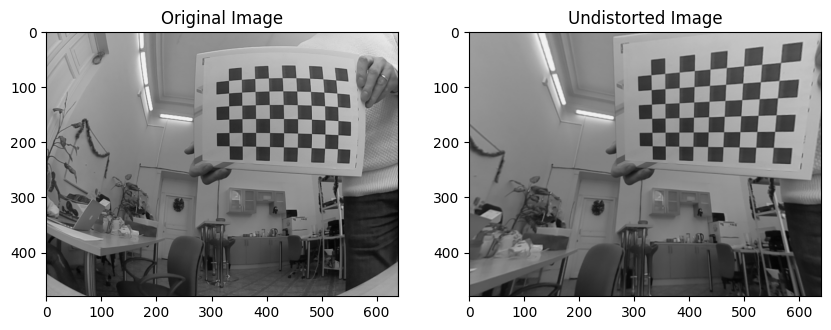

In [4]:
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
ret, K, D, _, _ = cv2.fisheye.calibrate(objpoints, imgpoints, image_size, K, D, rvecs, tvecs, flags,
                                        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, image_size, cv2.CV_16SC2)
image = cv2.imread(image_dir + "left_01.png")


undistorted_image = cv2.remap(image, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(undistorted_image)
plt.title("Undistorted Image")
plt.show()

In [5]:
original_images = []
undistorted_images = []

for i in range(1, number_of_images):
  image = cv2.imread(image_dir + "left_%02d.png" % i)
  undistorted_image = cv2.remap(image, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
  original_images.append(image)
  undistorted_images.append(undistorted_image)

In [6]:
def plot_original_and_undistorted_images(originals, distorted):
  imstack = np.zeros((originals[0].shape[0], originals[0].shape[1] * 2, 3), dtype=np.uint8)
  for i in range(len(originals)):
    imstack[:, :originals[i].shape[1], :] = originals[i]
    imstack[:, originals[i].shape[1]:, :] = distorted[i]
    cv2.imshow("Original and undistorted Images", imstack)
    cv2.waitKey(0)

plot_original_and_undistorted_images(original_images, undistorted_images)
cv2.destroyAllWindows()

In [7]:
def get_imgpoints(imgs):
  objpoints = []
  imgpoints = []
  for i in range(1, len(imgs)):
    gray = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (width, height), cv2.
    CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.
    CALIB_CB_NORMALIZE_IMAGE)
    Y, X, channels = img.shape

    if (ret == True):
      minRx = corners[:,:,0].min()
      maxRx = corners[:,:,0].max()
      minRy = corners[:,:,1].min()
      maxRy = corners[:,:,1].max()
      border_threshold_x = X/12
      border_threshold_y = Y/12

      x_thresh_bad = False
      if (minRx < border_threshold_x):
        x_thresh_bad = True

      y_thresh_bad = False
      if (minRy < border_threshold_y):
        y_thresh_bad = True

      if (y_thresh_bad==True) or (x_thresh_bad==True):
        continue
      
    if ret == True:
      objpoints.append(objp)
      corners2 = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)
      imgpoints.append(corners2)
    else:
      print("Chessboard couldn't detected. Image pair: ", i)
      continue
  return np.asarray(objpoints, dtype=np.float64), np.asarray(imgpoints, dtype=np.float64)

In [8]:
images_l = []
images_r = []

number_of_images = 15
for i in range(10, number_of_images):
  image_left = cv2.imread(image_dir + "left_%02d.png" % i)
  image_right = cv2.imread(image_dir + "right_%02d.png" % i)
  images_l.append(image_left)
  images_r.append(image_right)
objpoints_left, imgpoints_left = get_imgpoints(images_l)
objpoints_right, imgpoints_right = get_imgpoints(images_r)

In [9]:
def calibrate_single(objpoints, imgpoints, image_size):
  N_OK = len(objpoints)
  K = np.zeros((3, 3))
  D = np.zeros((4, 1))
  rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
  tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

  ret, K, D, _, _ = cv2.fisheye.calibrate(objpoints, imgpoints, image_size, K, D, rvecs, tvecs, flags, (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))
  return K, D

In [10]:
K_left, D_left = calibrate_single(objpoints_left, imgpoints_left, image_size)
K_right, D_right = calibrate_single(objpoints_right, imgpoints_right, image_size)

In [11]:
(RMS, _, _, _, _, rotationMatrix, translationVector) = cv2.fisheye.stereoCalibrate(
  objpoints_left, imgpoints_left, imgpoints_right,
  K_left, D_left, K_right, D_right,
  image_size, None, None,
  cv2.CALIB_FIX_INTRINSIC,
  (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01))

In [12]:
R2 = np.zeros([3,3])
P1 = np.zeros([3,4])
P2 = np.zeros([3,4])
Q = np.zeros([4,4])

(leftRectification, rightRectification, leftProjection, rightProjection,
  dispartityToDepthMap) = cv2.fisheye.stereoRectify(
  K_left, D_left,
  K_right, D_right,
  image_size,
  rotationMatrix, translationVector,
  0, R2, P1, P2, Q,
  cv2.CALIB_ZERO_DISPARITY, (0,0) , 0, 0)

In [13]:
map1_left, map2_left = cv2.fisheye.initUndistortRectifyMap(
  K_left, D_left, leftRectification, leftProjection, image_size, cv2.CV_16SC2)

map1_right, map2_right = cv2.fisheye.initUndistortRectifyMap(
  K_right, D_right, rightRectification, rightProjection, image_size, cv2.CV_16SC2)

In [14]:
image_left = cv2.imread(image_dir + "left_01.png")
image_right = cv2.imread(image_dir + "right_01.png")

image_left_undistorted = cv2.remap(image_left, map1_left, map2_left, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
image_right_undistorted = cv2.remap(image_right, map1_right, map2_right, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(image_left, "Original Left", (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
cv2.putText(image_right, "Original Right", (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
cv2.putText(image_left_undistorted, "Undistorted Left", (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
cv2.putText(image_right_undistorted, "Undistorted Right", (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

hstack = np.zeros((image_left.shape[0]* 2, image_left.shape[1] * 2, 3), dtype=np.uint8)
hstack[:image_left.shape[0], :image_left.shape[1], :] = image_left
hstack[:image_left.shape[0], image_left.shape[1]:, :] = image_right
hstack[image_left.shape[0]:, :image_left.shape[1], :] = image_left_undistorted
hstack[image_left.shape[0]:, image_left.shape[1]:, :] = image_right_undistorted

cv2.imshow("Original and undistorted images", hstack)
cv2.waitKey(0)

cv2.destroyAllWindows()

In [15]:
image_left = cv2.imread(image_dir + "left_01.png")
image_right = cv2.imread(image_dir + "right_01.png")

image_left_undistorted = cv2.remap(image_left, map1_left, map2_left, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
image_right_undistorted = cv2.remap(image_right, map1_right, map2_right, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

N, XX, YY = image_left_undistorted.shape[::-1]

visRectify = np.zeros((YY, XX*2, 3), np.uint8)
visRectify[:,0:XX:,:] = image_left_undistorted
visRectify[:,XX:XX*2:,:] = image_right_undistorted

for y in range(0,YY,10):
  cv2.line(visRectify, (0,y), (XX*2,y), (255,0,0))

cv2.imshow('visRectify',visRectify) 
cv2.waitKey(0)
cv2.destroyAllWindows()

In [16]:
# Samo obliczenie korespondencji stereo (mapy gł˛ebi, mapy dysparycji) jest stosunkowo proste
# (przynajmniej w teorii i dla odpowiednich zdj˛ec). Celem jest znalezienie o ile piksel ´ IL(x, y)
# jest przesuni˛ety (d – dysparycja) na drugim obrazie IR(x+d, y). Dla przypomnienia – szukamy
# tylko w liniach poziomych, bo zakładamy, ze obrazy poddane zostały rektyfikacji. Mo ˙ zna te ˙ z˙
# zauwazy˙ c,´ ze zadanie w pewnym sensie jest podobne do przepływu optycznego. Tylko tam ˙
# mielismy dwie kolejne ramki z sekwencji zarejestrowane jedn ˛a kamer ˛a, a tu dwa obrazy z dwóch ´
# 62 Kalibracja kamery i stereowizja
# kamer w tym samym czasie. Notabene, warto wiedziec,´ ze na podstawie sekwencji z pojedynczej ˙
# kamery tez mo ˙ zna odtworzy ˙ c gł˛ebi˛e – o ile kamera ta jest ruchoma – zagadnienie ´ Structure from
# Motion. 
# W bibliotece OpenCV dost˛epne s ˛a dwie metody obliczenia map gł˛ebi: dopasowanie bloków
# (Block Matching) i SGM (Semi-Global Matching). Działanie pierwszej jest dos´c oczywiste, ´
# w przypadku drugiej dokonuje si˛e równiez optymalizacji globalnej mapy dysparycji (w uprosz- ˙
# czonej formie), co pozwala poprawic ci ˛agło ´ s´c mapy. ´
# Zadanie 6.3 Prosz˛e samodzielnie, na podstawie dokumentacji, wyznaczyc map˛e dysparycji ´
# dla jednego z obrazów z folderu example przed i po procesie kalibracji. Parametry poszczególnych funkcji prosz˛e dobrac empirycznie, stosuj ˛ac si˛e do ogranicze ´ n. Wy ´ swietl obraz ´
# oryginalny przed i po kalibracji oraz odpowiednie mapy dysparycji (SGM i BM).
# Przykładowe rozwi ˛azanie zaprezentowano na rys. 6.4

In [17]:
def get_disparity_sgbm(left, right, map1_left, map2_left, map1_right, map2_right):
  #correct for lens distortion
  left_undistorted = cv2.remap(left, map1_left, map2_left, interpolation=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_CONSTANT)
  right_undistorted = cv2.remap(right, map1_right, map2_right, interpolation=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_CONSTANT)

  minDisparity=0
  numDisparities=16

  stereo_sbm = cv2.StereoSGBM_create(
    minDisparity=minDisparity,
    numDisparities=numDisparities,
    uniquenessRatio=10,
    preFilterCap=63,
  )

  disparity = stereo_sbm.compute(left_undistorted, right_undistorted)
  depth = cv2.reprojectImageTo3D(disparity, dispartityToDepthMap)

  disparity = disparity.astype(np.float32)

  disparity = (disparity/16.0 - minDisparity)/numDisparities
    
  return cv2.applyColorMap((disparity*255).astype(np.uint8), cv2.COLORMAP_JET), depth

In [18]:
left_images = []
right_images = []

num_img = 35
for i in range(1, num_img):
  image_left = cv2.imread(image_dir + "left_%02d.png" % i)
  image_right = cv2.imread(image_dir + "right_%02d.png" % i)
  image_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)
  image_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)
  images_l.append(image_left)
  images_r.append(image_right)

In [19]:
for i in range(1, num_img):
  disparity, depth = get_disparity_sgbm(images_l[i], images_r[i], map1_left, map2_left, map1_right, map2_right)
  stacked = np.hstack((disparity, depth))
  cv2.imshow("Disparity", stacked)
  
  cv2.waitKey(15)

cv2.destroyAllWindows()

In [20]:
def get_disparity_bm(left, right, map1_left, map2_left, map1_right, map2_right):
  # first correct for lens distortion
  left_undistorted = cv2.remap(left, map1_left, map2_left, interpolation=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_CONSTANT)
  right_undistorted = cv2.remap(right, map1_right, map2_right, interpolation=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_CONSTANT)

  cv2.imshow("left", left_undistorted)
  cv2.imshow("right", right_undistorted)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  # convert
  left_undistorted = cv2.cvtColor(left_undistorted, cv2.COLOR_BGR2GRAY)
  right_undistorted = cv2.cvtColor(right_undistorted, cv2.COLOR_BGR2GRAY)
  
  minDisparity=0
  numDisparities=16

  stereo_bm = cv2.StereoBM_create(
    numDisparities=numDisparities,
    blockSize=17
  )

  disparity = stereo_bm.compute(left_undistorted, right_undistorted)
  depth = cv2.reprojectImageTo3D(disparity, dispartityToDepthMap)
  disparity = disparity.astype(np.float32)

  disparity = (disparity/16.0 - minDisparity)/numDisparities
  
  
  return cv2.applyColorMap((disparity*255).astype(np.uint8), cv2.COLORMAP_JET), depth

In [21]:
disparity, depth = get_disparity_bm(images_l[1], images_r[1], map1_left, map2_left, map1_right, map2_right)
cv2.imshow("Disparity", disparity)
cv2.imshow("Depth", depth)
cv2.waitKey(11)
cv2.destroyAllWindows()

: 